# 12.850 - Assignment 2  |  Bryce Corlett

##Modeling Diffusion over Time
This program models diffusion in a 1D field with a time-varying forcing, using a no-slip bottom boundary condition, free-slip surface boundary condition, a Crank-Nicolson time iteration scheme, and an SOR iterative solving scheme. The SOR scheme used in Assignment 1 (and written below) is unable to solve matrix equations in which the right-hand side is negative; therefore, as stated below, in the interest of time, I have used the scipy sparse-matrix linear solver.

In [2]:
# Import clusters
from scipy import sparse #Allows me to create sparse matrices (i.e. not store all of the zeros in the 'A' matrix)
import scipy.sparse.linalg as spla #To solve each time iteration, as my SOR code (below) grows exponentially when attempting to solve with negative values on the right-hand side.
from numpy import * #To make matrices and do matrix manipulation
import matplotlib.pyplot as plt #for plotting purposes

%matplotlib inline

# Define Successive Over-Relaxation scheme
def sor(A,x,B,tolerance,w):
    '''This iteration scheme relaxes Gauss-Seidel estimates toward the converging value
    INPUTS:
    A = Relation Matrix
    x = initial estimated field
    B = boundary conditions
    tolerance = allowable difference between iterations
    w = SOR factor - usually 1.5, but seems to work best with 1.85
    
    OUTPUT:
    T = final estimated field'''
    
    # Initialize scheme
    resid = x[:,0].dot(100.)
    m = 0
    T=x[:,0]
        
    while mean(divide(resid,abs(B).max())*100)>tolerance:
        T=append(T,T[:,0].dot(0.),axis=1)
        for i in range(0,size(A,1)):
            #Calculate individual estimates
            cleaned_list1 = [ x for x in range(0,size(A,1)) if x < i ]#Previous Solutions
            cleaned_list2 = [ x for x in range(0,size(A,1)) if x > i ]#Future Solutions
            #Use estimates of T for next timestep
            T_hat=(B[i]-(A[i,cleaned_list1]*T[cleaned_list1,m+1])-(A[i,cleaned_list2]*T[cleaned_list2,m]))/A[i,i]
            T[i,m+1]=(w*T_hat)+((1-w)*T[i,m]) #Adjust based on relaxation factor

        resid=abs((A*T[:,m])-B)
        #print(str(mean(divide(resid,abs(B).max())*100))+'%')
        print('.'),
        m=m+1
    print('')
    return T[:,m-1]

##Motivation and Discretizing

This problem was motivated as an extension of the probelm I posed in Assignment 1; after solving for the velocity profile forced by a given barotropic tide (parameterized as a fixed surface slope), I proposed modeling the velocity profile under a time-dependent tide (taken to be a sinusoidal M2 tide, with a tidal period of 12.44 hours). In keeping with the earlier problem, I utilize a no-slip bottom boundary condition (taking $u_0$ equal to zero) and a free-slip surface boundary condition (where the flux to the surface is equal to zero). 

I begin with the Navier-Stokes equation for $u$:
$$\frac{\partial u}{\partial t} + u \cdot \nabla u = -\frac{1}{\rho}\frac{\partial p}{\partial x} + \frac{\partial}{\partial z}\left[K \frac{\partial u}{\partial z}\right] + F$$

where $u$ is the horizontal velocity, $K$ is an eddy diffusivity, and $\frac{\partial p}{\partial x}$ is the barotropic pressure gradient induced by one phase of the tide, similar to Assigment 1. I can now neglect advection and external forcings (as the forcing for the assignment will be contained within the pressure gradient). In addition, I assume hydrostatic conditions so that $\frac{\partial p}{\partial x} = \rho g \frac{\partial h}{\partial x}$. Our initial equation has now become:
$$\frac{\partial u}{\partial t} = -g\frac{\partial h}{\partial x} + \frac{\partial}{\partial z}\left[K \frac{\partial u}{\partial z}\right]$$

in which $\frac{\partial h}{\partial x}$ is prescribed. As I wish for the barotropic pressure gradient to vary in time (to simulate the M2 tide), I assume that $h = \eta\cos\left(2\pi\frac{time}{T_{tidal}}\right)$, where $T_{tidal}$ is the period of our tide (12.44 hours). Substituting for $h$ and rewriting:
$$\frac{\partial u}{\partial t} + g\cos\left(2\pi\frac{time}{T_{tidal}}\right)\frac{\partial \eta}{\partial x} = \frac{\partial}{\partial z}\left[K \frac{\partial u}{\partial z}\right]$$

Similar to Assignment 1, I am still prescribing the slope, but here it sets a maximum slope amplitude for the oscillating pressure gradient. In addition to the time-dependent forcing, the new acceleration term on the left-hand side requires a recalculation of the nondimensional parameter. After adjusting the parameters to reflect nondimensional quantities (shown with asterisks), I reach the following equation:
$$\frac{\partial u^{\ast}}{\partial t^{\ast}}+\frac{gT\eta H^{2}}{L\kappa U^{2}}\cos\left(2\pi\frac{time}{T_{tidal}}\right)\frac{\partial \eta^{\ast}}{\partial x^{\ast}} = \frac{\partial}{\partial z^{\ast}}\left[K^{\ast} \frac{\partial u^{\ast}}{\partial z^{\ast}}\right]$$

By simplifying the nondimensional quantity into a Reynolds number ($Re=\frac{HU}{\kappa}$), a Froude number ($Fr=\frac{U}{\sqrt{gH}}$), and taking $U = \frac{L}{T}$, I am able to reach the final equation: 
$$\frac{\partial u^{\ast}}{\partial t^{\ast}}+\frac{\eta}{U^{2}}\frac{Re}{Fr^{2}}\cos\left(2\pi\frac{time}{T_{tidal}}\right)\frac{\partial h^{\ast}}{\partial x^{\ast}} = \frac{\partial}{\partial z^{\ast}}\left[K^{\ast} \frac{\partial u^{\ast}}{\partial z^{\ast}}\right]$$

###Crank-Nicolson Stability Criterion

Having reached our nondimensional number, it is important to check on the stability of the problem. I begin by discretizing the equation using the Crank-Nicolson scheme, whereby $$u_{k}^{n+1} = u_{k}^{n} + \Delta t\left[ \frac{1}{2}\left(\frac{F_{k}^{n+1} - F_{k-1}^{n+1}}{\Delta z} + f_{k}^{n+1} \right) + \frac{1}{2}\left(\frac{F_{k}^{n} - F_{k-1}^{n}}{\Delta z} + f_{k}^{n} \right)\right] ; where~ F_{k}^{n} = \nu_{k}^{n}\left(\frac{u_{k+1}^{n} - u_{k}^{n}}{\Delta z} \right)$$

I take $u(x,t)_{j}^{n} = \sum u(t)^{n}e^{ikj \Delta x}$, decomposing by fourier series, and substitute into the discrete Crank-Nicolson scheme (assuming momentarily that $\Delta z_{f} = \Delta z_{c}$ and we have negligible forcing) to reach the following:
$$u(t)^{n+1} \left[e^{ik(j) \Delta x} - \frac{\Delta t}{2}\frac{\nu_{k}}{\Delta z^{2}} \left(e^{ik(j+1) \Delta x} - 2 e^{ik(j) \Delta x} + e^{ik(j-1) \Delta x} \right) \right] = u(t)^{n} \left[e^{ik(j) \Delta x} + \frac{\Delta t}{2}\frac{\nu_{k}}{\Delta z^{2}} \left(e^{ik(j+1) \Delta x} - 2 e^{ik(j) \Delta x} + e^{ik(j-1) \Delta x} \right) \right]$$

Dividing both sides by $e^{ikj \Delta x}$, and taking $e^{ik \Delta x} + e^{-ik \Delta x} = 2\cos(k \Delta x)$, the above equation simplifies to
$$\frac{u(t)^{n+1}}{u(t)^{n}} = \frac{\left[1+\frac{\Delta t}{2}\frac{\nu_{k}}{\Delta z^{2}}\left(2\cos (k \Delta x) -2 \right) \right]}{\left[1-\frac{\Delta t}{2}\frac{\nu_{k}}{\Delta z^{2}}\left(2\cos (k \Delta x) -2 \right) \right]}$$

Taking $\cos(k \Delta x) = 1 - 2\sin^{2}(k \Delta x)$ and rearranging, we find that the Crank-Nicolson scheme is stable under all conditions, as $\sin^{2}$ is always positive and the numerator is always smaller than the denominator:
$$\left|\frac{u(t)^{n+1}}{u(t)^{n}}\right| = \left|\frac{\left[1-2\Delta t\frac{\nu_{k}}{\Delta z^{2}}\sin^{2} (k \Delta x) \right]}{\left[1+2\Delta t\frac{\nu_{k}}{\Delta z^{2}}\sin^{2} (k \Delta x) \right]}\right| < 1$$


### Discretizing & Boundary Conditions

Building on the discretizing scheme presented above for time-stepping, I solve the discrete equation to isolate 'n+1' terms to the left-hand side and 'n' terms to the right-hand side:
$$\frac{2}{\Delta t}u_{k}^{n+1} - \left[ \frac{\nu_{k}^{n+1}}{\Delta z_{c}}\left(\frac{u_{k+1}^{n+1} - u_{k}^{n+1}}{\Delta z_{f}} \right) - \frac{\nu_{k-1}^{n+1}}{\Delta z_{c}}\left(\frac{u_{k}^{n+1} - u_{k-1}^{n+1}}{\Delta z_{f}} \right) + f_{k}^{n+1}\right] = \frac{2}{\Delta t}u_{k}^{n} + \left[ \frac{\nu_{k}^{n}}{\Delta z_{c}}\left(\frac{u_{k+1}^{n} - u_{k}^{n}}{\Delta z_{f}} \right) - \frac{\nu_{k-1}^{n}}{\Delta z_{c}}\left(\frac{u_{k}^{n} - u_{k-1}^{n}}{\Delta z_{f}} \right) + f_{k}^{n}\right]$$

I can further simplify the problem into our unknown terms and known values, isolating each $u$:
$$\left[\frac{-\nu_{k}^{n+1}}{\Delta z_{f} \Delta z_{c}}\right]u_{k+1}^{n+1} + \left[\frac{2}{\Delta t} + \frac{\nu_{k}^{n+1}}{\Delta z_{f} \Delta z_{c}} + \frac{\nu_{k-1}^{n+1}}{\Delta z_{f} \Delta z_{c}}\right]u_{k}^{n+1} + \left[\frac{-\nu_{k-1}^{n+1}}{\Delta z_{f} \Delta z_{c}}\right]u_{k-1}^{n+1} = \left[\frac{\nu_{k}^{n+1}}{\Delta z_{f} \Delta z_{c}}\right]u_{k+1}^{n} + \left[\frac{2}{\Delta t} - \frac{\nu_{k}^{n}}{\Delta z_{f} \Delta z_{c}} - \frac{\nu_{k-1}^{n}}{\Delta z_{f} \Delta z_{c}}\right]u_{k}^{n} + \left[\frac{\nu_{k-1}^{n}}{\Delta z_{f} \Delta z_{c}}\right]u_{k-1}^{n} + \left[f_{k}^{n+1}+f_{k}^{n}\right]$$

I chose to implement the discrete equation as is, in which $[A][u]^{n+1} = [B][u]^{n} + f^{n+1}+f^{n}$, where the forcings are identical for all grid cells. In the code below, I solve for the matrices $[A]$ and $[B]$ at the same time, calculate the right-hand side of our equation, then use the right-hand side in combination with $[A]$ to solve for $[u]^{n+1}$. 

Similar to Assignment 1, the bottom boundary condition is implemented by setting $u_{-1}=0$ (which appears in the lack of a $u_{k-1}$ term when solving for $u_{0}$) and the surface boundary condition is implemented by setting the flux above the grid cell ($F_{k}$) equal to zero for the surface cell. These boundary conditions adjust the values within the matrices $[A]$ and $[B]$, but do not affect the matrix $[u]^{n}$ as the parameters are set equal to zero. As a result, the boundary condition matrix when solving for the initial conditions is simply composed of the barotropic pressure gradient. 

In order to show these values, the code below has been adjusted to show matrix $[A]$ and the right-hand side of the equation when solving for $[u]^{n+1}$ in the first time iteration.


In [14]:
def cranknicolson(T,T_del,Timesteps,n,eta,u0,U,Fr,Re,K):
    '''This iteration scheme moves a Gauss-Seidel estimate forward at a given time interval using a Crank-Nicolson scheme
    
    INPUTS:
    T = Period of forcing fluctuations
    T_del = timestep
    Timesteps = number of timesteps to move forward
    n = number of depth bins
    eta = amplitude of sinusoidal forcing
    u0 = bottom boundary condition
    U = mean barotropic velocity
    Fr = Froude number of flow
    Re = Reynolds number of flow
    K = diffusivity matrix
    
    OUTPUT:
    Time = time field
    Depth = depth field (grid center)
    Q = final estimated field over time'''

    #K=ones(n+1)
    #K=array(range(1,n+2))
    #K=array(range(n+2,1,-1))
    K=K/float(max(K)) #Nondimensionalize K

    # Define distances at Face (F) and Center (C) = ensure nondimensionalized
    Z_f=range(-n,0,1);Z_f=[x / float(n) for x in Z_f];Z_f=append(append([-1-(1/float(n))],Z_f),[0]);Z_f=Z_f[0:size(Z_f)-1]+(diff(Z_f))/2.0;
    Z_c=range(-n,0,1);Z_c=[x / float(n) for x in Z_c];Z_c=append(append([-1-(1/float(n))],Z_c),[0]); 

    #Begin stepping forward in time
    for time in range(0,Timesteps):
        #Solve for initial state using boundary conditions

        #Construct A matrix - dependent on time iteration scheme
        if time == 0: #Solving for initial conditions
            print(time),
            # Construct 'A' Matrix
            A=zeros((n,n))
            for item in range(1,n+1): #Start from bed and work to surface
                if item>1:
                    A[item-1,item-2]=-(K[item-1]/((Z_f[item]-Z_f[item-1])*(Z_c[item]-Z_c[item-1])) )
                    
                A[item-1,item-1]=+( (K[item-1]/((Z_f[item]-Z_f[item-1])*(Z_c[item]-Z_c[item-1]))) + (K[item]/((Z_f[item]-Z_f[item-1])*(Z_c[item+1]-Z_c[item]))) )
                if item == n: #Sets free-slip boundary condition at the surface
                    A[item-1,item-1]=+( (K[item-1]/((Z_f[item]-Z_f[item-1])*(Z_c[item]-Z_c[item-1]))) )
                    
                if item != n:
                    A[item-1,item]=-(K[item]/((Z_f[item]-Z_f[item-1])*(Z_c[item+1]-Z_c[item])) )

            # Construct Boundary Condition Matrix = using non-dimensional parameter
            b=ones(size(A,1))*(Re/(Fr*Fr))*((eta/(U*U))*cos(2*pi*(float(time)/T)))
            b[0]=b[0] + (u0* (K[item-1]/((Z_f[item]-Z_f[item-1])*(Z_c[item]-Z_c[item-1]))) ) #Because u0 is zero, this line does nothing.

            # Define + Apply guess + boundary conditions
            x=matrix(b[:]).T
            b=matrix(b).T

            # Solve Problem using hard-wired iterative scheme
            #T = jacobi(A,x,b,0.05)
            #T = gaussseidel(A,x,b,0.05)
            Q = sor(A,x,b,0.05,1.85)
            
        #Iterate forward in time using the Crank-Nicolson scheme
        else:
            print(', '+str(time)),
            Q=append(Q,Q[:,0].dot(0.),axis=1) #increase size to match time dimension
    
            # Construct 'A' Matrix
            A=zeros((3,n)) # For solving for 'n+1' solution
            B=zeros((3,n)) # For using 'n' solution
            for item in range(1,n+1): #Start from bed and work to surface
                #j-1
                if item>1: 
                    A[0,item-2]=-(K[item-1]/((Z_f[item]-Z_f[item-1])*(Z_c[item]-Z_c[item-1])) )
                    B[0,item-2]=+(K[item-1]/((Z_f[item]-Z_f[item-1])*(Z_c[item]-Z_c[item-1])) )
                    
                #j
                A[1,item-1]=+(2/T_del)+( (K[item-1]/((Z_f[item]-Z_f[item-1])*(Z_c[item]-Z_c[item-1]))) + (K[item]/((Z_f[item]-Z_f[item-1])*(Z_c[item+1]-Z_c[item]))) )
                B[1,item-1]=+(2/T_del)-( (K[item-1]/((Z_f[item]-Z_f[item-1])*(Z_c[item]-Z_c[item-1]))) + (K[item]/((Z_f[item]-Z_f[item-1])*(Z_c[item+1]-Z_c[item]))) )

                if item == n: #Sets free-slip boundary condition at the surface
                    A[1,item-1]=+(2/T_del)+( (K[item-1]/((Z_f[item]-Z_f[item-1])*(Z_c[item]-Z_c[item-1]))) )
                    B[1,item-1]=+(2/T_del)-( (K[item-1]/((Z_f[item]-Z_f[item-1])*(Z_c[item]-Z_c[item-1]))) )

                #j+1
                if item != n:
                    A[2,item]=-(K[item]/((Z_f[item]-Z_f[item-1])*(Z_c[item+1]-Z_c[item])) )
                    B[2,item]=+(K[item]/((Z_f[item]-Z_f[item-1])*(Z_c[item+1]-Z_c[item])) )
                    
            A = sparse.spdiags(A,array([-1,0,1]),n,n)
            B = sparse.spdiags(B,array([-1,0,1]),n,n)

            RHS = B.dot(Q[:,time-1]) 
            RHS[0] = RHS[0] + (u0* (K[item-1]/((Z_f[item]-Z_f[item-1])*(Z_c[item]-Z_c[item-1]))) ) #Because u0 is zero, this line does nothing.
            RHS = RHS + (Re/(Fr*Fr))*((eta/(U*U))*cos(2*pi*((float(time-1)*T_del)/T))) + (Re/(Fr*Fr))*((eta/(U*U))*cos(2*pi*((float(time-1)*T_del)/T)))

            #To show the matrix A and boundary conditions for the first time-step
            if time == 1:
                print(A)
                print(RHS)
            
            Q[:,time] = matrix(spla.spsolve( sparse.csr_matrix(A.toarray()),RHS)).T
            #Q[:,time] = sor(matrix(A.toarray()),RHS,RHS,0.05,1.85) #There is an issue with my SOR code in which it does not like to solve equations with negative values on the right-hand side.

    Time = matrix(range(0,Timesteps))*T_del
    Depth = Z_c
    
    return [Time,Depth,Q] 
    

##Running the Program

Having reduced the equation to a discrete form of nondimensional terms (with the key dimensionless constant $\frac{Re}{Fr^{2}}\frac{\eta}{U^{2}}$ ), I was able to proceed to solving for the time-varying solution.

While first writing the code, I ran into numerous bugs in the process of writing the proper discretized equations (confusing signs for the '$\eta+1$' and '$\eta$' matrices), and discovered that my SOR code only works properly when the right-hand side of the equation (the boundary conditions) is positive and when the left-hand side of the equation is an array (as opposed to a sparse matrix).

As the solution using my personal SOR code grows logarithmically with time (due to the issues mentioned above), and in the interest of time, I have made use of the scipy sparse-matrix linear solver, as I have implimented sparse matrices in this assignment to allow for efficient computation of high-resolution problems. One added benefit to this is the drastic reduction in computation time caused by solving using sparse matrices (in which the zeros with matrix $[A]$ are not stored). The parameters for the initial run are specified below.

In [15]:
## Begin Program

eta = 0.001 #m of sea level anomaly
U=1 #mean velocity
H=1.0 #depth of the water column
K=1e-2

Fr = U/sqrt(9.81*H) #Froude number from given conditions
Re = (H*U)/K #Reynolds number from a specified maximum diffusivity

# Set number of cells = similar to resolution, as cells are evenly placed between -1 and 0.
n = 25

# Set bottom boundary condition
u0 = 0

# Create K matrix
K=ones(n+1)*K

print('The dimensionless constant = '+str((Re/(Fr*Fr))*((eta/(U*U))))) #The dimensionless constant

The dimensionless constant = 0.981


In [16]:
## Run the Crank-Nicolson scheme, having initialized the fields
[Time,Depth,Q]=cranknicolson(12.44,0.5,40,n,eta,u0,U,Fr,Re,K)

0 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 
, 1   (1, 0)	-625.0
  (2, 1)	-625.0
  (3, 2)	-625.0
  (4, 3)	-625.0
  (5, 4)	-625.0
  (6, 5)	-625.0
  (7, 6)	-625.0
  (8, 7)	-625.0
  (9, 8)	-625.0
  (10, 9)	-625.0
  (11, 10)	-625.0
  (12, 11)	-625.0
  (13, 12)	-625.0
  (14, 13)	-625.0
  (15, 14)	-625.0
  (16, 15)	-625.0
  (17, 16)	-625.0
  (18, 17)	-625.0
  (19, 18)	-625.0
  (20, 19)	-625.0
  (21, 20)	-625.0
  (22, 21)	-625.0
  (23, 22)	-625.0
  (24, 23)	-625.0
  (0, 0)	1254.0
  :	:
  (24, 24)	629.0
  (0, 1)	-625.0
  (1, 2)	-625.0
  (2, 3)	-625.0
  (3, 4)	-625.0
  (4, 5)	-625.0
  (5, 6)	-625.0
  (6, 7)	-625.0
  (7, 8)	-625.0
  (8, 9)	-625.0
  (9, 10)	-625.0
  (10, 11)	-625.0
  (11, 12)	-625.0
  (12, 13)	-625.0
  (13, 14)	-625.0
  (14, 15)	-625.0
  (15, 16)	-625.0
  (16, 1

##Checking the Forcing
To check that the sinusoidal pressure gradient forcing is inducing a reasonable time-dependent signal in the velocity, I'm plotting the nondimensional surface velocity ($u^{\ast}$) against time. It looks correct, as I'm inducing a pressure gradient dependent on $\cos\left(\frac{time}{T_{tidal}}\right)$, and the surface velocity follows the trend of the forcing (being at the free-slip surface condition).

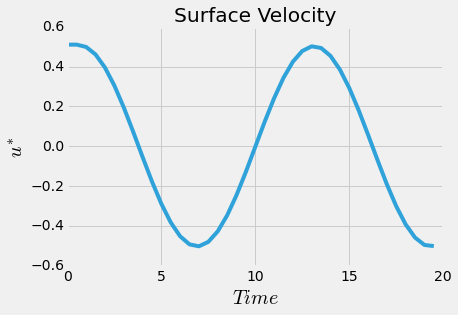

In [17]:
# Plot of Surface Velocity
plt.style.use('fivethirtyeight')
plt.plot(Time.T,Q[n-1,:].T)#,linewidth=2,marker='o')
plt.title('Surface Velocity')
plt.ylabel(r'$u^{\ast}$', fontsize=20)
plt.xlabel(r'$Time$', fontsize=20)
#plt.savefig('SurfaceVel.pdf', format='pdf', dpi=1200)

##The velocity field over time
Having run the semi-implicit Crank-Nicolson scheme forward in time through one tidal cycle, I checked to ensure that the scheme was producing reasonable velocity profiles. 

In the figure below, I've shown the velocity profile changing over one half of the tidal cycle, smoothly switching directions as the forced pressure gradient changes sign. The result appears to be accurate; as the diffusivity is constant throughout the water column, each grid cell adjusts to the barotropic pressure gradient without retaining information from the previous timestep. In essence, the forward steps through time in this case could have been modelled independently and joined into a single matrix after the calculations.

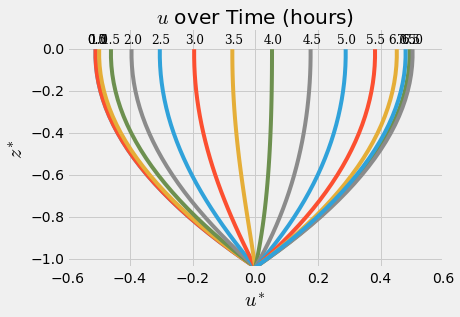

In [18]:
#Plot of changes over time
plt.figure()
plt.style.use('fivethirtyeight')
for int in range(0,16):
    #lines=plt.plot(append(Q[:,int],Q[19,int]),(matrix([range(0,20)]).T/20.0))
    lines=plt.plot(-append(append(Q[0,0]*0,Q[:,int*1]),Q[size(Q,0)-1,int*1]),matrix(Depth).T) #Append boundary conditions
    plt.text(-Q[size(Q,0)-1,int*1]-0.025, 0.03, (Time[0,int]*1), fontproperties='serif', fontsize=12)
    #plt.setp(lines, linewidth=2.0)
plt.title('$u$ over Time (hours)')
plt.ylim([Depth.min(),0.1]);#plt.xlim([-5e6,5e6])
plt.ylabel(r'$z^{\ast}$', fontsize=20)
plt.xlabel(r'$u^{\ast}$', fontsize=20)
plt.grid('on')
#plt.legend(['0','20','40','60','80','100','120'])
#plt.xscale('log')
plt.show()



##Variations on the Problem - Linear Diffusivity

To vary the conditions going into the problem, I first decided to adjust the diffusivity field to more accurately portray a decrease in mixing as you move down through the water column. The figure immediately below reflects the new linear diffusivity profile.

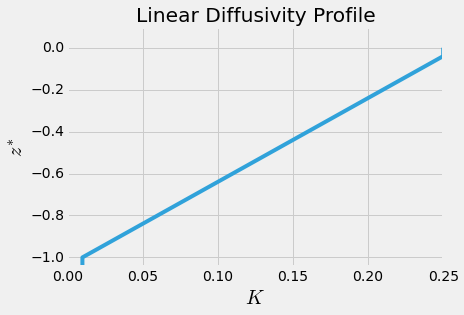

0 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 

In [19]:
# Create K matrix
K=ones(n+1)*(10**-2)
new=list(arange(1,n+1))
for l in new:
    K[l]=(K[l]*float(l)) #New varying diffusivity, with higher values closer to the surface

# Plot diffusivity profile
plt.plot(append(K,K[n]),Depth)
plt.title('Linear Diffusivity Profile')
plt.ylim([Depth.min(),0.1])
plt.ylabel(r'$z^{\ast}$', fontsize=20)
plt.xlabel(r'$K$', fontsize=20)
plt.show()

## Re-Run the Crank-Nicolson scheme, having initialized the fields
[Time,Depth,Q]=cranknicolson(12.44,0.5,40,n,eta,u0,U,Fr,Re,K)

The plot below illustrates the effects of the linear diffusivity profile; the most grabbing adjustment is the asymmetry of the solution due to the initial condition. I'm not sure why the initial profile is provides an extreme starting point for the time iteration scheme, but plotting over longer periods of time (i.e. a full tidal cycle) reveals that the stable surface velocity maxima are between -1.5 and 1.5 $u^{\ast}$. Focussing on the smaller deviations, you can barely see the effects of the linear diffusivity near -1.8 $z^{\ast}$, in which the grid cells closer to the bathymetry adjust to the forcing at a slightly faster rate than the cells near the surface. 

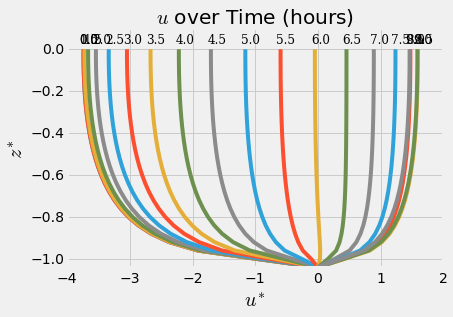

In [20]:
#Plot of changes over time
plt.figure()
plt.style.use('fivethirtyeight')
for int in range(0,20):
    lines=plt.plot(-append(append(Q[0,0]*0,Q[:,int*1]),Q[size(Q,0)-1,int*1]),matrix(Depth).T) #Append boundary conditions
    plt.text(-Q[size(Q,0)-1,int*1]-0.05, 0.03, (Time[0,int]*1), fontproperties='serif', fontsize=12)
    #plt.setp(lines, linewidth=2.0)
plt.title('$u$ over Time (hours)')
plt.ylim([Depth.min(),0.1]);#plt.xlim([-5e6,5e6])
plt.ylabel(r'$z^{\ast}$', fontsize=20)
plt.xlabel(r'$u^{\ast}$', fontsize=20)
plt.grid('on')

##Variations on the Problem - Higher temporal resolution

Having seen the flow respond more realistically to the barotropic forcing with the linear diffusivity profile, I was still interested to see how well the process could be resolved temporally. To this end, the following code includes the linear diffusivity profile used above in conjunction with a time-step of 0.1 instead of 0.5 hours. 

In [21]:
## Re-Run the Crank-Nicolson scheme, having initialized the fields
[Time,Depth,Q]=cranknicolson(12.44,0.1,180,n,eta,u0,U,Fr,Re,K)

0 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 

As shown in the figure below, the code is able to resolve temporal variability quite well, including the adjustment of the flow from the very strong negative velocities to slightly weaker positive ones. The realistic problem could be further improved with a logarithmic diffusivity, but it is nice to see that the velocity profile is responding as it ought to with a linear $\nu$ profile. 

It appears that even without a pressure gradient (approximately hour 6 of our cosine-based M2 tide), there is a depth-uniform nonzero velocity profile. This appears to be an indication of another bug in the code, but it could be a reaction of the system to the over-estimated initial conditions, relaxing quickly to the opposite sign. However, the model with larger timesteps accurately placed the 6-hour velocity profile about zero, so perhaps it is an issue with time-stepping. 

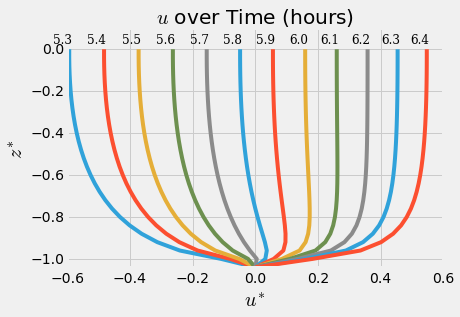

In [22]:
#Plot of changes over time
plt.figure()
plt.style.use('fivethirtyeight')
for int in range(53,65):
    lines=plt.plot(-append(append(Q[0,0]*0,Q[:,int*1]),Q[size(Q,0)-1,int*1]),matrix(Depth).T) #Append boundary conditions
    plt.text(-Q[size(Q,0)-1,int*1]-0.05, 0.03, (Time[0,int]*1), fontproperties='serif', fontsize=12)
    #plt.setp(lines, linewidth=2.0)
plt.title('$u$ over Time (hours)')
plt.ylim([Depth.min(),0.1]);#plt.xlim([-5e6,5e6])
plt.ylabel(r'$z^{\ast}$', fontsize=20)
plt.xlabel(r'$u^{\ast}$', fontsize=20)
plt.grid('on')

To briefly check the output of the model, I am showing the surface velocity pattern in the figure below. It's quite clear that the initial conditions are an over-estimate of the velocities produced at the peak of the tide, but I'm not sure what has caused this error to pop up, as the initial conditions are independent of the time-step; I'll be coming back to this in the next few days to find the root of the issue, as I do not have the time to do so now.

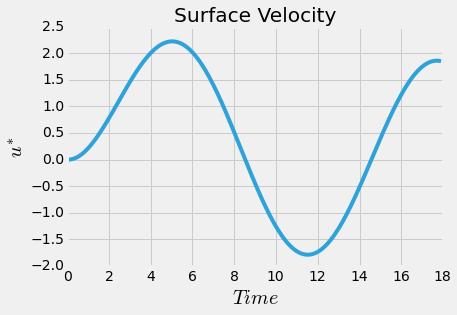

In [13]:
# Plot of Surface Velocity
plt.style.use('fivethirtyeight')
plt.plot(Time.T,Q[n-1,:].T)#,linewidth=2,marker='o')
plt.title('Surface Velocity')
plt.ylabel(r'$u^{\ast}$', fontsize=20)
plt.xlabel(r'$Time$', fontsize=20)
#plt.savefig('SurfaceVel.pdf', format='pdf', dpi=1200)

##Lessons from the Problem

I have learned quite a bit this week, from going through the iteration process to troubleshooting almost all of the code to find out that the primary bug was in the previous week's SOR code. My primary objective of learning to implement the Crank-Nicolson scheme was realized, after understanding how important signs are when constructing matrices. In addition, I was surprised to find how much time was gained by implementing sparse matrices into the solving method rather than storing all numbers within matrices $[A]$ and $[B]$. 

Having increased the complexity of my original problem posed in Assignment 1, it is quite clear that these simple models can be used to diagnose effects of single parameters, and increasing the temporal and spatial resolution of the problem can allow you to pinpoint effects that would easily be missed in field studies. These models are great for forming an intuition of processes; however, as they become increasingly complex, it is increasingly important to write the models efficiently and clearly. In the coming week(s), I plan to revisit this problem to check over my code for bugs related to the time-step issue noted in the section above, and to correct the SOR code to run (correctly) with sparse matrices.
